# Simulations of the wave equation and sonar algorithms

_Author_: Jonathan Gjertsen  
_Last updated_: 2018-08-05

## Objectives

The goal of this notebook is to

* understand the behaviour of the wave equation in the presence of sounds (sources), objects and noise
* develop effective algorithms for echolocation (active sonar) and detecting the origin of sounds (passive sonar) using an array of microphones

## Table of contents

1. _The wave equation_
  1. _The continuous wave equation_
  1. _Discretization of the wave equation_
    1. _Discretization of $\partial^2 f/\partial t^2$_
    1. _Discretization of $\nabla^2 f$_
    1. _The discretized wave equation_
1. _Implementation in Python_
  1. _Fast calculation of $\nabla^2 f(x,y)$_
    1. _Principle_
    1. _Demo_
  1. _Solving the equation_
    1. _Simulation domain and initial conditions_
    1. _Sources_
    1. _Objects_
    1. _Noise_
    1. _Simulation program_
  1. _Demo_
    1. _Setting up the simulation domain_
    1. _Plotting the results_
1. _Active sonar_
  1. _Microphone setup_
  1. _Signal processing_
    1. _Partitioning_
    1. _Echo detection with cross-correlation_
    1. _Object detection algorithm_
  1. _Animation and video_
1. _Passive sonar_

# 1 The wave equation

## 1.A The continuous wave equation

The continuous wave equation with no source term (i.e., the _homogenous_ wave equation) in 2D is

$$
\frac{\partial^2 f}{\partial t^2}-c^2\nabla^2 f=0
$$

Adding a source term $s(x, y, t)$ to the right side results in the _inhomogenous_ wave equation:

$$
\frac{\partial^2 f}{\partial t^2}-c^2\nabla^2 f = s
$$

$f$ and $s$ are both functions of $t$, $x$ and $y$.


## 1.B Discretization of the wave equation

### 1.B.a Discretization of $\partial^2 f / \partial t^2$

We use the Taylor series to expand $f(t+\tau)$ and $f(t-\tau)$ in terms of $f(t)$ and its derivatives:

$$
f(t+\tau) = f(t) + \tau\frac{\partial f}{\partial t}(t) + \frac{\tau^2}{2}\frac{\partial^2 f}{\partial t^2}(t) + \frac{\tau^3}{6}\frac{\partial^3 f}{\partial t^3}(t) + ... O(\tau^4) \\
f(t-\tau) = f(t) - \tau\frac{\partial f}{\partial t}(t) + \frac{\tau^2}{2}\frac{\partial^2 f}{\partial t^2}(t) - \frac{\tau^3}{6}\frac{\partial^3 f}{\partial t^3}(t) + ... O(\tau^4) \\
$$

Add the two together:

$$
f(t+\tau)+f(t-\tau) = 2f(t)+2\frac{\tau^2}{2}\frac{\partial^2 f}{\partial t^2}(t) + ... O(\tau^4)
$$

Rearrange:

$$
\frac{\partial^2 f}{\partial t^2}(t) = \frac{1}{\tau^2}\left(f(t+\tau)+f(t-\tau)-2f(t)\right) + ... O(\tau^2)
$$

The error is increased to $O(\tau^2)$ because of the division by $\tau^2$. In a simulation with time step $\tau$, we get the approximation

$$
\frac{\partial^2 f}{\partial t^2}_t = \frac{1}{\tau^2}\left(f_{t+1} + f_{t-1} - 2f_t\right)
$$

In other words, the curvature of $f$ with respect to time at time $t$ is high when its previous and future value is very different from its current value.

### 1.B.b Discretization of $\nabla^2 f$

We use the same approach as previously, but now we expand the values of $f(x,y)$ a small distance $h$ away from $(x,y)$ in each of the four directions in the grid:

$$
f(x+h,y) = f(x,y)+h\frac{\partial f}{\partial x}(x,y)+\frac{h^2}{2}\frac{\partial^2 f}{\partial x^2}(x,y)+\frac{h^3}{6}\frac{\partial^3 f}{\partial x^3}(x,y)+...O(h^4) \\
f(x-h,y) = f(x,y)-h\frac{\partial f}{\partial x}(x,y)+\frac{h^2}{2}\frac{\partial^2 f}{\partial x^2}(x,y)-\frac{h^3}{6}\frac{\partial^3 f}{\partial x^3}(x,y)+...O(h^4) \\
f(x,y+h) = f(x,y)+h\frac{\partial f}{\partial y}(x,y)+\frac{h^2}{2}\frac{\partial^2 f}{\partial y^2}(x,y)+\frac{h^3}{6}\frac{\partial^3 f}{\partial y^3}(x,y)+...O(h^4) \\
f(x,y-h) = f(x,y)-h\frac{\partial f}{\partial y}(x,y)+\frac{h^2}{2}\frac{\partial^2 f}{\partial y^2}(x,y)-\frac{h^3}{6}\frac{\partial^3 f}{\partial y^3}(x,y)+...O(h^4) \\
$$

Adding the four lines:

$$
f(x+h,y)+f(x-h,y)+f(x,y+h)+f(x,y-h) =
4f(x,y)+2\frac{h^2}{2}\frac{\partial^2 f}{\partial x^2}(x,y)+2\frac{h^2}{2}\frac{\partial^2 f}{\partial y^2}(x,y)+...O(h^4)
$$

Since $2\frac{h^2}{2}\frac{\partial^2 f}{\partial x^2}(x,y)+2\frac{h^2}{2}\frac{\partial^2 f}{\partial y^2}(x,y)=h^2\nabla^2f(x,y)$, we can simplify to

$$
f(x+h,y)+f(x-h,y)+f(x,y+h)+f(x,y-h) = 4f(x,y)+h^2\nabla^2f(x,y)+...O(h^4)
$$

Rearrange in terms of $\nabla^2f(x,y)$:

$$
\nabla^2 f(x,y) = \frac{1}{h^2}\left(f(x+h,y)+f(x-h,y)+f(x,y+h)+f(x,y-h) - 4f(x,y)\right)+...O(h^2)
$$

The error is increased to $O(h^2)$ because of the division by $h^2$. On a grid with pixel size $h$, we get the approximation

$$
\nabla^2 f_{x,y}=\frac{1}{h^2}\left(f_{x+1,y}+f_{x-1,y}+f_{x,y-1}+f_{x,y+1}-4f_{x,y}\right)
$$

In other words, the curvature of $f$ with respect to space at $(x,y)$ is high when the average of its neightbouring values are very different from its own value.

### 1.B.c The discretized wave equation

We have a $w\times h$ pixel grid of points $(x,y)$ where $x=0,1,...,w-1$ and $y=0,1,...,h-1$. It exists at times $t=0,1,...,n-1$ where $n$ is the number of frames. At each location $(x,y)$ and timestep $t$, we have

$$
\frac{\partial^2 f}{\partial t^2}_{t,x,y} - c^2\nabla^2 f_{t,x,y} = s_{t,x,y}
$$

Substituting $\frac{\partial^2 f}{\partial t^2}_{t,x,y}=f_{t+1,x,y} + f_{t-1,x,y} - 2f_{t,x,y}$ and $\nabla^2 f_{t,x,y}=\left(f_{t,x+1,y}+f_{t,x-1,y}+f_{t,x,y-1}+f_{t,x,y+1}-4f_{t,x,y}\right)$, we get

$$
f_{t+1,x,y} + f_{t-1,x,y} - 2f_{t,x,y} - c^2\left(f_{t,x+1,y}+f_{t,x-1,y}+f_{t,x,y-1}+f_{t,x,y+1}-4f_{t,x,y}\right) = s_{t,x,y}
$$

which we rearrange to get $f_{t+1,x,y}$:

$$
f_{t+1,x,y} = - f_{t-1,x,y} + 2f_{t,x,y} + c^2\left(f_{t,x+1,y}+f_{t,x-1,y}+f_{t,x,y-1}+f_{t,x,y+1}-4f_{t,x,y}\right) + s_{t,x,y}
$$

To perform the simulation, we start out with known values for $f_{0, x, y}$ and $f_{1, x, y}$ as our initial conditions and advance the simulation for each timestep $t=2,...,n-1$. This is more or less fast enough for the simulations performed here, and a reasonably-sized simulation (less than 1000x1000 pixel grid and less than 10000 frames) can be performed in a few minutes. Smaller simulations (512 x 512 pixels, 500 frames) can be performed in a few seconds. For larger simulations, the above equation can be expressed as a matrix equation in which the system matrix is symmetric and sparse, so the calculations can be sped up by factorizing the matrix (e.g. with Cholesky decomposition).

# 2 Implementation in Python

For a simulation of $N$ frames on a square grid with $L\times L$ pixels, we need to calculate $f_{t+1,x,y}$ about $NL^2$ times. For example, if $N=1000$ and $L=128$, we need to perform the calculation about 16 million times. Doing this with for loops in Python is rather slow. The first step to speeding up the simulation is to only use vectorizable `numpy` operations for the number crunching.

## 2.A Fast calculation of $\nabla^2 f(x,y)$

### 2.A.a Principle

The calculation of $\nabla^2 f(x,y)$ can be made reasonably fast by using `numpy` primitives. In the `laplace_op` function below, we use `np.roll` to create four copies of `f_xy` which are shifted in each direction. We then perform the calculation using these shifted copies and the original `f_xy`. These are all vectorizable operations and are performed much faster than performing the calculations element-wise.

When using `np.roll` like this, the elements which are shifted off the edges reappear on the other side. We are therefore implicitly imposing a _periodic boundary condition_ where the left edge of the simulation domain is assumed to be connected to the right edge, and the top edge is assumed to be connected to the bottom edge.

In [1]:
import numpy as np

def laplace_op(f_xy: np.ndarray) -> np.ndarray:
    '''Returns the Laplace operator of f_xy under periodic boundary conditions.
    
    The return value has the same dimensions as f_xy.
    '''
    # Create copies of f_xy, shifted in each direction
    left = np.roll(f_xy, -1, axis=0)
    right = np.roll(f_xy, +1, axis=0)
    up = np.roll(f_xy, -1, axis=1)
    down = np.roll(f_xy, +1, axis=1)
    
    # Perform the calculation
    return left + right + up + down - 4 * f_xy

### 2.A.b Demo

As a demonstration, we create a 2D signal and compute its Laplace operator. We choose a radial sinc function $f(r)=\frac{\sin(r)}{r}$ (where $r=\sqrt{x^2+y^2}$) as our signal because it looks pretty.

In [2]:
from collections import namedtuple

Coord2d = namedtuple('Coord2d', 'x y')
Coord2d.__doc__ = '''Representation of a 2D coordinate (can be pixels or real distances)'''

def demo_signal_grid(size_pixels: int, size_real: float) -> (np.ndarray, np.ndarray):
    '''Initialize a pixel grid into which the signal should be placed'''
    # Let the x and y coordinates vary from -size_real/2 to +size_real/2 along the box
    x = np.linspace(-size_real / 2, size_real / 2, demo_size)
    y = np.copy(x)

    # xx and yy are 2D matrixes which hold the x- and y-coordinates of each point
    xx, yy = np.meshgrid(x, y)
    
    return xx, yy

def demo_signal(xx: np.ndarray, yy: np.ndarray, center: Coord2d = (0, 0)) -> np.ndarray:
    '''Returns a 2D array with a radially symmetric sinc function centered around the center of the array,
    or around another point if <center> is provided.'''
    # rr is a 2D matrix which holds the radial coordinate
    rr = np.sqrt((xx - center.x) ** 2 + (yy - center.y) ** 2)

    # Apply the sinc function to each point to obtain the result
    return np.sinc(rr)

And here is the full demonstration with plots. There are a couple of problems. Firstly, the magnitude of the calculated laplacian is too low compared to the analytically calculated value. Secondly, the value is very high around the borders. Neither of these problems seem to affect the simulations. For display purposes, the borders of the plot of the laplacian are cropped away.

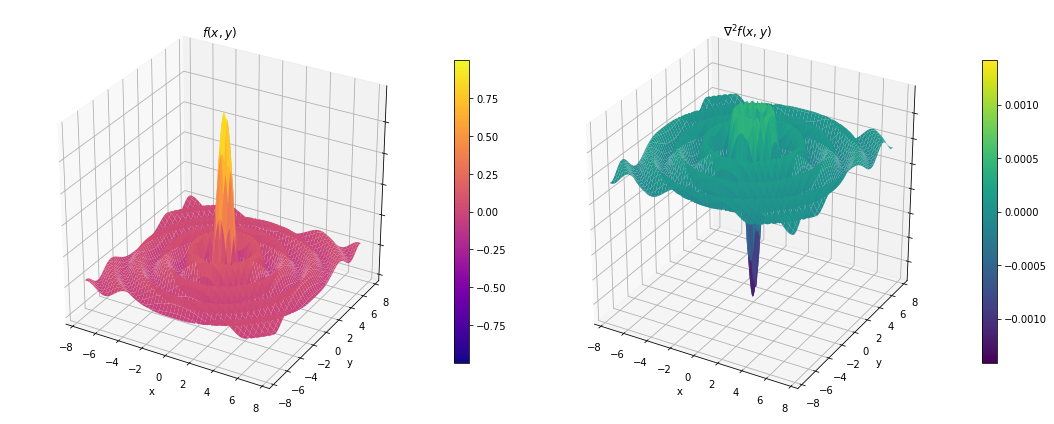

In [33]:
from matplotlib import cm, rc, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def adjust_surf_plot(fig, ax, surf):
    '''Perform adjustments common to both plots'''
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zticklabels([])
    fig.colorbar(
        surf,
        ax=ax,
        shrink=0.75
    )

# Demonstration parameters
demo_size = 1024
demo_real_size = 15
shift = Coord2d(x=0, y=0)

# Generate signal
xx, yy = demo_signal_grid(size_pixels=demo_size, size_real=demo_real_size)
f_xy = demo_signal(xx, yy, shift)

# Compute Laplace operator
laplace = laplace_op(f_xy)

# Create subplots
fig = plt.figure(figsize=(15,6))
f_ax = fig.add_subplot(1, 2, 1, projection='3d')

# Plot f_xy
f_xy_absmax = np.max(np.abs(f_xy))
f_surf = f_ax.plot_surface(
    xx, yy, f_xy,
    cmap=cm.plasma,
    vmin=-f_xy_absmax,
    vmax=f_xy_absmax
)
f_ax.set_title('$f(x, y)$')
adjust_surf_plot(fig, f_ax, f_surf)

# Plot the Laplace op (with cropped edges)
laplace_xx, laplace_yy, laplace = xx[1:-2, 1:-2], yy[1:-2, 1:-2], laplace[1:-2, 1:-2]
laplace_ax = fig.add_subplot(1, 2, 2, projection='3d')
laplace_absmax = np.max(np.abs(laplace))
laplace_surf = laplace_ax.plot_surface(
    laplace_xx, laplace_yy, laplace,
    cmap=cm.viridis,
    vmin=-laplace_absmax,
    vmax=laplace_absmax
)
laplace_ax.set_title('$\\nabla^2 f(x, y)$')
adjust_surf_plot(fig, laplace_ax, laplace_surf)

# Display
plt.tight_layout()
plt.show()

## 2.B Solving the equation

To keep the code somewhat clean, we first define a few concepts.

### 2.B.a Simulation domain and initial conditions
The simulation domain is a box with a certain width and height. We also associate the number of frames with the simulation domain, as well as the initial conditions $f_{0,x,y}$ and $f_{1,x,y}$ which are represented as 2D numpy arrays. When initializing the simulation, we set $f_{0,x,y}=f_{1,x,y}=0$ if it is not provided.

In [4]:
SimulationDomain = namedtuple('SimulationDomain', 'frames width height initial_conditions')
SimulationDomain.__doc__ = '''Representation of a simulation domain'''

InitialConditions = namedtuple('InitialConditions', 'pprev prev')
InitialConditions.__doc__ = '''Representation of the two previous states of a simulation'''

def initialize_wave_sim(domain: SimulationDomain) -> np.ndarray:
    '''Create and return a numpy array to hold the result of the simulation. Fill the first two frames with the initial conditions.'''
    # Initialize all frames with zeros
    seq = np.zeros((domain.frames, domain.width, domain.height), dtype='float64')
    
    # Set two first frames based on initial conditions, if any
    if domain.initial_conditions is not None:
        seq[0] = domain.initial_conditions.pprev
        seq[1] = domain.initial_conditions.prev
    
    return seq

### 2.B.b Sources

There can be any number $n_s$ of sources $s_{i, t, x, y}$ in the simulation. The source term in the discretized wave equation is the sum of these sources,
$$
s_{t,x,y}=\sum_{i=0}^{n_s}s_{i, t, x, y}
$$
To keep things simple, we assume the sources to be approximate point sources (fixed $x,y$) playing a time-dependent signal $s_{i,t}$. In order to avoid sharp edges in the simulation, the point sources are spread over a small region with a Gaussian function. 

In [5]:
from typing import Iterable

from scipy.signal import gaussian

Source = namedtuple('Source', 'signal coord spread')
Source.__doc__ = '''Representation of a source with a signal and a coordinate'''

def make_gaussian_2d(source_spread: int = 5) -> np.ndarray:
    '''Make a 2D window to smush the audio sources over a Gaussian with radius r=point_spread'''
    std = source_spread / 5
    gaussian_1d = gaussian(2 * source_spread, std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    
    return gaussian_2d

def add_source_contributions(seq: np.ndarray, t: int, spread_funcs: np.ndarray, sources: Iterable[Source]):
    '''Add the contribution from the source signals at time t to the simulation'''
    for source, spread_func in zip(sources, spread_funcs):
        # Abbreviate variable names
        coord = source.coord
        r = source_spread
        
        # Add the source signal at time t, smushed over a gaussian
        seq[t, coord.x-r:coord.x+r, coord.y-r:coord.y+r] = (
            seq[t, coord.x-r:coord.x+r, coord.y-r:coord.y+r]
            + spread_func * source.signal[t]
        )

### 2.B.c Objects

There can be any number of $n_o$ rectangular objects in the simulation. When a sound wave collides with one of these objects, it is reflected. The boundary condition corresponding to reflection is the no-flux condition

$$
\nabla f_{\text{border of object}}=0
$$

For this condition to hold, $f_{x,y}$ must be locally symmetric about the border of the object. For a rectangular object, it should be possible to implement this by copying the value of the pixel just outside of the box to the pixel just inside the box before advancing the simulation. The results did not seem right: waves would appear to propagate through the box and emerge on the other side, and the reflected waves had the opposite sign as the incoming waves. These problems aside, the no-flux condition would be challenging to implement for geometries other than a rectangular object or perhaps a circle.

For now, I am instead using the mirroring condition:

$$
f_{\text{border of object}}=0
$$

The effect is the same as the reflecting boundary condition, except that the reflected wave has the opposite sign as the incoming wave (i.e., the same result as previously, but now it is _expected_). It is also trivial to implement for any geometry: just zero the region corresponding to the object before advancing the simulation.

In [6]:
RectangularObject = namedtuple('RectangularObject', 'bottom_left top_right')
RectangularObject.__doc__ = '''Representation of a rectangular object with a bottom left and top right coordinate'''

def add_object_contributions(seq: np.ndarray, t: int, objects: Iterable[RectangularObject]):
    '''Zero the region corresponding to the object at time t.'''
    for obj in objects:
        # Abbreviate variable names
        bl_x, bl_y, tr_x, tr_y = obj.bottom_left.x, obj.bottom_left.y, obj.top_right.x, obj.top_right.y

        # Apply mirroring boundary condition
        seq[t, bl_x:tr_x, bl_y:tr_y] = 0

### 2.B.d Noise

Noise can be modelled as a point source producing a noise signal, or just as a random fluctuation in $f$. I found that adding noise during each time step in the simulation caused the signal to grow out of control everywhere (video: https://www.youtube.com/watch?v=ZG2hJtShB-4). This result makes sense in that adding noise at each timestep is like having a little source at each pixel constantly contributing energy to the system (and since the boundary conditions are periodic, there is no way for this energy to leave the system).

To avoid this problem, the simulation is run to completion and noise is added to every time step. This is kind of overkill, it is probably better to just run a noise-free simulation and then add noise to the model of the microphones.

In [7]:
from numpy.random import uniform

def add_noise_contribution(domain: SimulationDomain, seq: np.ndarray, noise: float):
    seq = seq + uniform(-noise, noise, (domain.frames, domain.width, domain.height))

### 2.B.e Simulation program

The `wave_sim` function runs a simulation based on a domain, a tuple of sources, a value for the speed of sound, and an optional tuple of rectangular objects.

In [8]:
from typing import Optional

def wave_sim(domain: SimulationDomain, sources: Iterable[Source], c: float, objects: Optional[Iterable[RectangularObject]] = None, noise: float = 0) -> np.ndarray:
    # Initialize simulation
    seq = initialize_wave_sim(domain)
    
    # Create a spatial spreading function for each source
    spread_funcs = tuple(make_gaussian_2d(source.spread) for source in sources)

    # Calculate c^2
    c_squared = c ** 2
    
    # Iterate through time steps
    for t in range(2, domain.frames):
        # Critical section: advance simulation
        seq[t] = c_squared * laplace_op(seq[t-1]) - seq[t-2] + 2 * seq[t-1]
        
        # Add source contributions from audio sources
        add_source_contributions(seq=seq, t=t, spread_funcs=spread_funcs, sources=sources)
        
        # Add objects
        if objects is not None:
            add_object_contributions(seq=seq, t=t, objects=objects)
    
    # Add noise
    if noise > 0:
        add_noise_contribution(domain=domain, seq=seq, noise=noise)
    
    return seq

## 2.C Demo

Let's set up the conditions for a simulation and run it.

### 2.C.a Setting up the simulation domain

For our simulation domain, we use a square box with zeroed initial conditions

In [9]:
length = 512
domain = SimulationDomain(
    frames=1000,
    width=length,
    height=length,
    initial_conditions=None
)

The configuration or sources is more or less an artistic choice. I use chirplets as the source signal here, inspired by the pings used in actual sonar and radar. Wavelets or clicks might work too.

In [10]:
from numpy.random import randint
from scipy.signal import chirp

def source_signal(tau: np.ndarray) -> np.ndarray:
    '''Create a chirplet to be used as a source signal'''
    # Arbitrary parameters
    chirp_speed = 5
    chirp_min_freq = 0.3
    chirp_max_freq = 1
    decay_speed = 0.5
    
    # Create chirp
    chirp_sig = chirp(chirp_speed * tau, chirp_min_freq, chirp_speed * tau[-1], chirp_max_freq)
    
    # Multiply by a Gaussian to create a chirplet
    chirplet = chirp_sig * np.exp(-(decay_speed * tau) ** 2)
    return chirplet

def create_sources(n_sources: int, domain: SimulationDomain, space_spread:int, time_spread: int, amp: float=1.0):
    sources = []
    for i in range(n_sources):
        # Preallocate signal
        signal = np.zeros(domain.frames)
        
        # Arbitrary time basis
        tau = np.linspace(-4, 4, time_spread)

        # Put the first source in the center
        if i == 0:
            delay = 0
            x = domain.width // 2
            y = domain.height // 2
        # Place the other ones randomly
        else:
            delay = randint(low=0, high=domain.frames // 4)
            x = randint(domain.width // 4, 3 * domain.width // 4)
            y = randint(domain.height // 4, 3 * domain.height // 4)

        # Use a chirplet as the source signal
        chirplet = source_signal(tau)
        signal[delay:delay + source_time_spread] = chirplet * amp

        # Create source and add it to the list
        sources.append(Source(signal, Coord2d(x, y), spread=space_spread))
    return sources

Here are the parameters. For now, use only one source with a small spread. Make the signal length about one tenth of the length of the simulation, set the source amplitude to 1 and put it at the center.

In [11]:
# Source parameters
n_sources = 1
source_spread = 2
source_time_spread = domain.frames // 10
source_amp = 1.0

sources = create_sources(
    n_sources=n_sources,
    domain=domain,
    space_spread=source_spread,
    time_spread=source_time_spread,
    amp=source_amp
)

The noise is set to around 0.1% (-60dB) compared to the source amplitude, which corresponds to pretty good real-life conditions, e.g. a loud ping (90dB) in a quiet room (30dB)

In [12]:
noise_amp = source_amp / 0.001

The location of objects is an artistic choice as well:

In [13]:
def create_objects(n_objects: int, domain: SimulationDomain, obj_width: int, obj_height: int):
    objects = []
    for i in range(n_objects):
        if i == 0:
            # Put the first object in a predefined location
            x = domain.width // 3
            y = domain.height // 3
        else:
            # Create random center coordinate for the others
            x = randint(randint(domain.width // 3, 2 * domain.width // 3))
            y = randint(randint(domain.height // 3, 2 * domain.height // 3))

        # Add a box
        objects.append(
            RectangularObject(
                bottom_left=Coord2d(x - obj_width // 2, y - obj_height // 2),
                top_right=Coord2d(x + obj_width // 2, y + obj_height // 2)
            )
        )
    return objects

Let's just have one mid-sized object for now:

In [14]:
### Object parameters
n_objects = 1
obj_width = length // 8
obj_height = length // 8

objects = create_objects(
    n_objects=n_objects,
    domain=domain,
    obj_width=obj_width,
    obj_height=obj_height,
)

We need to choose the speed of sound, in units of pixels per timestep. It must be smaller than 1 px/step, and I found that the simulations would sometimes grow exponentially for $c$ > 0.4 px/step. We are interested in what happens between when the source signal is played and when the wave hits the edge of the boundary and starts to wrap around. We use this fact to set the optimal speed of sound while limiting it to at most 0.4 px/step:

In [15]:
### Speed of sound
optimal_c = (length / (2 * domain.frames))
max_c = 0.4
c = min(optimal_c, max_c)

print(f"The speed of sound is {c:.2f} pixels per timestep.")

The speed of sound is 0.26 pixels per timestep.


When the speed of sound is fixed, we can choose the simulation domain to be of an appropriate size and get the meters per pixel as well as the number of seconds per timestep.

In [16]:
### Calculated physical values
c_si = 343 # Physical speed of sound [m / s]
length_si = 1 # Physical length [m]
meters_per_pixel = length_si / length # Meters per pixel [m/px]
seconds_per_timestep = (c / c_si) * meters_per_pixel # Seconds per timestep [s/step]

print(f"The timestep is {seconds_per_timestep*10e6:.2f} µs.")
print(f"The simulation duration is {domain.frames*seconds_per_timestep*1000:.2f} ms.")

The timestep is 14.58 µs.
The simulation duration is 1.46 ms.


Let's plot the waveform of the source signal(s) and the simulation domain:

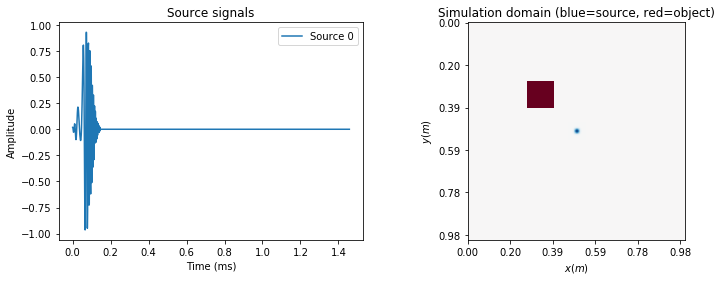

In [17]:
def set_real_ticks(image_ax):
    image_ax.set_xticklabels([f'{tick * meters_per_pixel:.2f}' for tick in image_ax.get_xticks()])
    image_ax.set_yticklabels([f'{tick * meters_per_pixel:.2f}' for tick in image_ax.get_yticks()])
    image_ax.set_xlabel('$x (m)$')
    image_ax.set_ylabel('$y (m)$')

t = np.linspace(0, domain.frames * seconds_per_timestep, domain.frames)

fig = plt.figure(figsize=(12,4))
signal_ax = fig.add_subplot(1, 2, 1)
image_ax = fig.add_subplot(1, 2, 2)

# Plot signals
legend = []
for i, source in enumerate(sources):
    signal_ax.plot(t * 1000, source.signal)
    legend.append(f'Source {i}')

signal_ax.legend(legend)
signal_ax.set_title('Source signals')
signal_ax.set_xlabel('Time (ms)')
signal_ax.set_ylabel('Amplitude')

# Plot simulation domain
imshow_data = np.zeros((domain.width, domain.height))
image_ax.imshow(imshow_data)
for source in sources:
    imshow_data[
        source.coord.x-20:source.coord.x+20,
        source.coord.y-20:source.coord.y+20
    ] = make_gaussian_2d(20)

for obj in objects:
    imshow_data[
        obj.bottom_left.x:obj.top_right.x,
        obj.bottom_left.y:obj.top_right.y
    ] = -1

image_ax.imshow(
    imshow_data,
    cmap=cm.RdBu,
    vmin=-1,
    vmax=1
)

set_real_ticks(image_ax)
image_ax.set_title('Simulation domain (blue=source, red=object)')

plt.show()

Now we run the simulation and store the result:

In [18]:
import time

print(f'Simulation settings:')
print(f'\tGrid:           {domain.width} × {domain.height}')
print(f'\tFrames:         {domain.frames}')
print(f'\tSpeed of sound: {c:.2f} px/step')
print(f'\tSources:        {len(sources)}')
print(f'\tObjects:        {len(objects)}')
print(f'\nRunning simulation\n')

t_prev = time.time()
dataset = wave_sim(domain=domain, sources=sources, c=c, objects=objects, noise=noise_amp)

print(f'Simulation performed in {time.time()-t_prev:.2f} seconds')

Simulation settings:
	Grid:           512 × 512
	Frames:         1000
	Speed of sound: 0.26 px/step
	Sources:        1
	Objects:        1

Running simulation

Simulation performed in 19.49 seconds


### 2.3.2 Plotting the results

The amplitude in the center of a source is very high in the center relative to the amplitude of the propagating soundwave and its echoes. The color range therefore needs to be squashed or truncated to see the echoes. Based on seeing what works, it seems that a good value for the top of the color range is about 20% of the maximum amplitude for a source.

In [19]:
# Purely empirical scaling values
scaling = source_amp * 0.2
vmin = -scaling
vmax = scaling

We add objects to the view by messing with the display data

In [20]:
display_data = np.copy(dataset)
for obj in objects:
    display_data[
        :,
        obj.bottom_left.x:obj.top_right.x,
        obj.bottom_left.y:obj.top_right.y
    ] = vmin

Here are figures for 6 distinct points in the simulation:

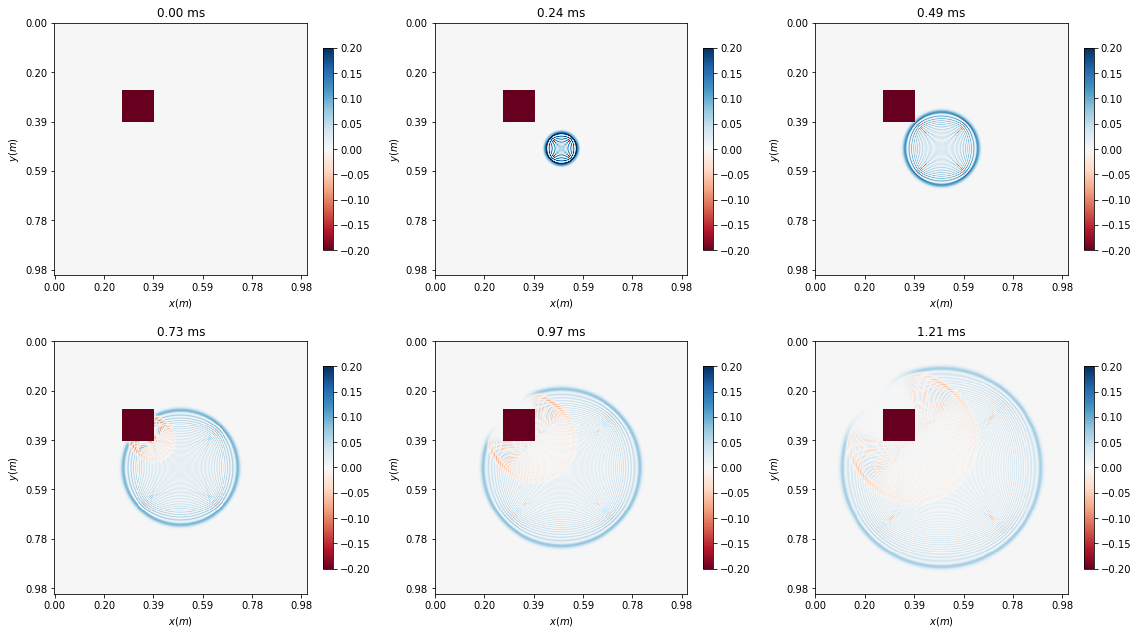

In [21]:
n_figures = 6

fig, axes = plt.subplots(2, int(np.ceil(n_figures / 2)), figsize=(16,9))
axes = axes.flatten()

for ax, i in zip(axes, range(n_figures)):
    step = i * domain.frames // n_figures
    
    image = ax.imshow(
        display_data[step],
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax,
        cmap=cm.RdBu
    )
    
    ax.set_title(f'{seconds_per_timestep*step*1000:.2f} ms')
    set_real_ticks(ax)
    
    plt.colorbar(image, ax=ax, shrink=0.75)

plt.tight_layout()
plt.show()

The sound wave is generated, propagates away from the source, hits the box and is reflected. It also changes sign, which as discussed previously would not happen in a real reflection. The region behind the object is in the "shadow" of the sound wave, but a listener behind the box would still hear something due to some of the sound waves bending around it.

We also see that the amplitude of the wave decays as its energy is spread over a larger and larger ring. This decay goes as $1/r$ in 2D. In 3D, the sound wave spreads over a larger and larger ball, so the amplitude decays as $1/r^2$, following an inverse square law. That's is the main difference between this 2D simulation and a 2D slice of a 3D simulation. In practice, it means that the sounds (in passive sonar) and echoes (in passive sonar) will be a lot quieter than what the simulated microphones pick up. If we only use the time difference of arrival between the microphones to estimate the distance and direction of sound sources or objects, the algorithm in the simulations and the real microcontroller can be the same. If we also try to revise the estimates by using the amplitude of the received signals, we need to modify the code in the real microcontroller to use the inverse square law instead of the $1/r$ dependence in the 2D simulation.

# 3 Active sonar

Now that we have a simulation of how the sound behaves, let's also try to make a sonar system. The central source in the above simulation corresponds to the sound source used in active sonar. We place $n$ microphones in a ring around this sound source. The ring configuration is just for simplicity: it makes all microphones equivalent, and all microphones receive the signal at about the same time.

For now, we only try to determine the location of a single object in an otherwise empty room. There will therefore only be one distinct echo. Since we know when the signal was sent out from the speaker as well as its waveform, we can use cross-correlation (in the signal processing sense) to determine the difference between the original sound and the echo for each microphone. We then know the distance from the object to the source. The location of the microphone relative to the source is known a priori (it is part of the sonar design), so we can calculate the distance from the object to the microphone. With 2 microphones, we can in principle figure out that the object must be in one of 2 points. With 3 microphones, we can in principle know the exact location of the object. In reality, we only have an estimate. By using more than 3 microphones, we can improve this estimate.

## 3.A Microphone setup

Here is a function to create the microphones:

In [22]:
def make_mics(dataset: np.ndarray, domain: SimulationDomain, n: int, r: float):
    '''Makes n microphones in a ring of radius r around the center of the domain'''
    # Microphone angles
    angles = [2*np.pi*i/n for i in range(n)]

    # Microphone coordinates
    mics = [
        Coord2d(
            x=domain.width / 2 + r * np.cos(angle),
            y=domain.height / 2 + r * np.sin(angle)
        )
    for angle in angles]
    
    # Sampled signals at each microphone
    signals = [dataset[:, int(mic.x), int(mic.y)] for mic in mics]
    
    return mics, signals

And here we create them:

In [23]:
# Make microphones
n_mics = 6
r = length / 16
mics, signals = make_mics(dataset, domain=domain, n=6, r=length/16)

print(f'{n_mics} microphones created in a ring of radius {r * meters_per_pixel * 100:.2f} cm around the source')

6 microphones created in a ring of radius 6.25 cm around the source


## 3.B Signal processing
### 3.B.a Partitioning
We start recording the source signal at time $t_i=r/c$, i.e., when the signal reaches the microphones. We stop recording the source signal at time $t_f=t_i+\Delta t$, where $\Delta t$ is the duration of the signal. The remaining signal contains echoes, noise etc.

In [24]:
signal_start = int(r / c)
signal_end = int(signal_start + source_time_spread)

pre_signals = [sig[signal_start:signal_end] for sig in signals]
post_signals = [-sig[signal_end:] for sig in signals]

### 3.B.b Echo detection with cross-correlation

The cross-correlation $(f\star g)_t$ between two signals $f_t$ and $g_t$ is used to detect the precense of $f(t)$ in $g(t)$ or vice versa. In the discrete domain, it is defined as
$$
(f\star g)_t = \sum_{m=-\infty}^{+\infty} f_tg_{t+m}
$$
For sonar, $f(t)$ is the source signal and $g(t)$ is the remaining signal. Echoes of the source signal will show up as peaks above the noise in the cross-correlation signal. We use this information to determine the time of the echoes (we could also use it to get information about the amplitude of the echoes).

In [25]:
from scipy.signal import unit_impulse

# Calculate correlation signals
correlations = [np.correlate(post_signal, pre_signal) for pre_signal, post_signal in zip(pre_signals, post_signals)]

# Determine the time of the peak of the correlation signals
peaks = [np.argmax(corr) for corr in correlations]

# This is just used to plot the location of the peaks
peak_locs = [unit_impulse(shape=len(corr), idx=np.argmax(corr)) for corr in correlations]

Below are plots of the sonar signal and echo as received by the microphones, the cross-correlation and the corresponding peak detection signal.

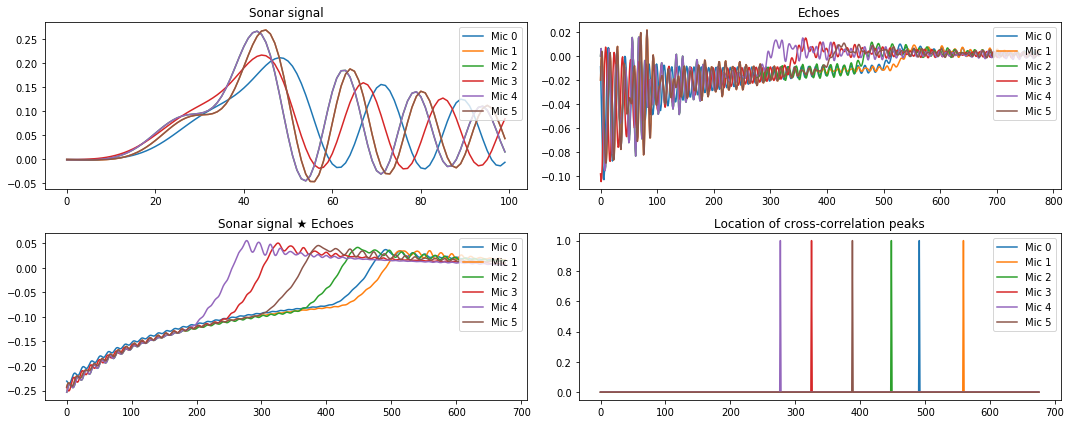

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
axes = axes.flatten()
pre_ax, post_ax, corr_ax, peak_ax = axes

for sig in pre_signals: pre_ax.plot(sig)
for sig in post_signals: post_ax.plot(sig)
for corr in correlations: corr_ax.plot(corr)
for peak in peak_locs: peak_ax.plot(peak)

for ax in axes:
    ax.legend([f'Mic {i}' for i in range(len(signals))], loc='upper right')

pre_ax.set_title('Sonar signal')
post_ax.set_title('Echoes')
corr_ax.set_title('Sonar signal ★ Echoes')
peak_ax.set_title('Location of cross-correlation peaks')
plt.tight_layout()

## 3.B.c Object detection algorithm

The algorithm that I came up with is as follows. It only works for finding a single object and it is horrifically inefficient (not feasible in a microcontroller), but it is fast enough for this purpose, and it does accurately find the object if the noise is not too high.

* Imagine rings of size $r_i=t_{\text{peak}}/c$ around each of the $n$ microphones
* Find all of the $n(n-1)/2$ intersection points between these $n$ rings
* Of these intersection points, there should be a cluster of $n$ points, corresponding to the location of the object. To find this cluster:
 * If the number of points is small enough, go through all of the $\binom{(n(n-1)/2}{n}$ combinations of $n$ points and calculate the total sum of square distances. This sum should be way smaller for the correct cluster than for the wrong ones
 * If the binomial coefficient is too high, divide the domain into 4 quadrants and run the cluster finding algorithm on the quadrant with the largest number of intersection points.
* Predict that the object is located at $(\overline{x}, \overline{y})$, the centroid of the $n$-point cluster.

Here is the intersection finding algorithm:

In [27]:
from itertools import combinations

from scipy.special import binom

def find_intersections(center_1: Coord2d, center_2: Coord2d, r_1: float, r_2: float):
    '''Calculate intersection of 2 circles
    
    Adapted from 'Two circles intersection calculator'
        url: http://www.ambrsoft.com/TrigoCalc/Circles2/circle2intersection/CircleCircleIntersection.htm
    '''
    x_1, y_1 = center_1
    x_2, y_2 = center_2
    d = np.sqrt((x_2-x_1) ** 2 + (y_2 - y_1) ** 2)
    
    # No intersection if the circles are too small, or if one circle contains the other
    if r_1 + r_2 < d or abs(r_2 - r_1) >= d:
        return None
    
    common_factor = (1 / (2 * d ** 2)) * np.sqrt((d + r_1 + r_2) * (d + r_1 - r_2) * (d - r_1 + r_2) * (-d + r_1 + r_2))
    
    x_const = ((x_1 + x_2) / 2) + (x_2 - x_1) * (r_1 ** 2 - r_2 **2) / (2 * d ** 2)
    y_const = ((y_1 + y_2) / 2) + (y_2 - y_1) * (r_1 ** 2 - r_2 **2) / (2 * d ** 2)
    
    return (
        Coord2d(
            x = x_const + (y_1 - y_2) * common_factor,
            y = y_const - (x_1 - x_2) * common_factor,
        ),
        Coord2d(
            x = x_const - (y_1 - y_2) * common_factor,
            y = y_const + (x_1 - x_2) * common_factor,
        ),
    )

def find_all_intersections(mics, peaks):
    assert len(mics) == len(peaks)
    intersections = []
    for i in range(len(mics)):
        r_i = peaks[i] * c
        center_i = mics[i]
        for j in range(i, len(mics)):
            r_j = peaks[j] * c
            center_j = mics[j]
            points = find_intersections(center_i, center_j, r_i, r_j)
            if points is not None:
                intersections.extend(points)
    return intersections

Here we find the intersections:

In [28]:
peak_shift = signal_end
intersections = find_all_intersections(mics=mics, peaks=peaks)

Here is the cluster finding algorithm:

In [29]:
def brute_force_cluster(intersections, cluster_size, max_it=1e6):
    combis = combinations(intersections, cluster_size)
    min_dist = np.inf
    min_combi = None
    it = 0
    for combi in combis:
        # Check number of iterations
        it += 1
        if it > max_it:
            return None, np.inf
        
        # Calculate total distance
        d = 0
        for ii in combi:
            for ij in combi:
                d += (ij.x-ii.x) ** 2 + (ij.y-ii.y) ** 2
                if d > min_dist:
                    break
            if d > min_dist:
                break
        
        # Check against competitor
        if d < min_dist:
            min_dist = d
            min_combi = combi

    if min_combi is None:
        return None, min_dist

    xes = [ii.x for ii in min_combi]
    ys = [ii.y for ii in min_combi]
    
    prediction = Coord2d(
        x=np.mean(xes),
        y=np.mean(ys),
    )
    
    return prediction, np.sqrt(np.var(xes) + np.var(ys))

def recursive_cluster(intersections, cluster_size, brute_force_threshold=1e7):
    binom_coeff = binom(len(intersections), cluster_size)
    if binom_coeff < brute_force_threshold:
        return brute_force_cluster(intersections, cluster_size, max_it=brute_force_threshold)
    
    xs = [ii.x for ii in intersections]
    ys = [ii.y for ii in intersections]
    
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    half_x = (max_x + min_x)/2
    half_y = (max_y + min_y)/2
    
    quadrants = (
        [ii for ii in intersections if ii.x < half_x and ii.y < half_y],
        [ii for ii in intersections if ii.x > half_x and ii.y < half_y],
        [ii for ii in intersections if ii.x < half_x and ii.y > half_y],
        [ii for ii in intersections if ii.x > half_x and ii.y > half_y],
    )
    
    max_q = max(len(quadrant) for quadrant in quadrants)
    quadrant = 0
    for quadrant in quadrants:
        q = len(quadrant)
        if q == max_q:
            return recursive_cluster(quadrant, cluster_size)

And here we run it:

In [30]:
prediction, std = recursive_cluster(intersections, len(mics))

Here is a visualization of the source, the intersections, and the true and predicted location of the object.

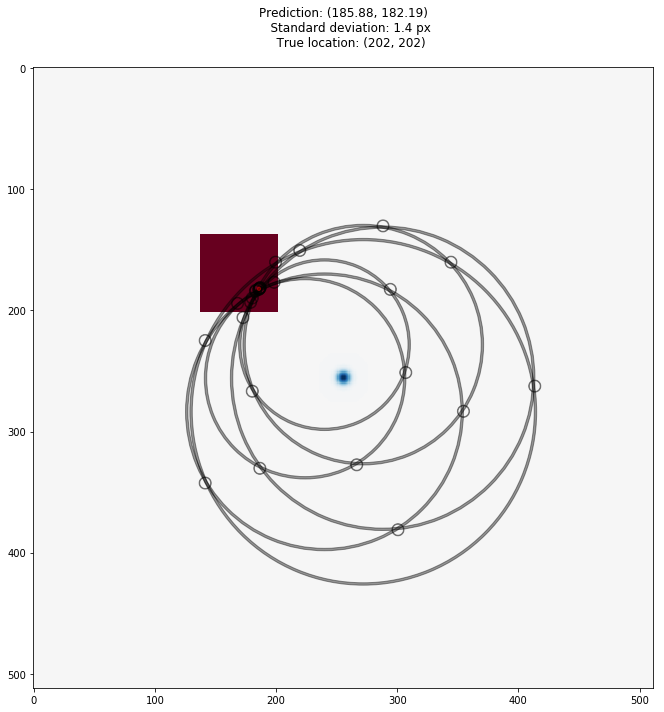

In [31]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

# Set up figure (just reuse the data from when we visualized the domain earlier)
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.imshow(
    imshow_data,
    cmap=cm.RdBu
)

# Draw each of the rings around the microphones
patches = []
for i, (mic, peak) in enumerate(zip(mics, peaks)):
    patches.append(
        Wedge(
            center=(mic.x, mic.y),
            r=peak * c,
            theta1=0,
            theta2=360,
            width=2,
        ),
    )
    
# Draw a marker for each of the intersections
for intersection in intersections:
    patches.append(
        Wedge(
            center=(intersection.x, intersection.y),
            r=5,
            theta1=0,
            theta2=360,
            width=0.5,
        ),
    )

# Add all of those circles to the image
ax.add_collection(PatchCollection(patches, color='k', alpha=0.4))

# Indicate the predicted position of the object (radius = standard deviation)
if prediction is not None:
    ax.add_patch(Circle(xy=(prediction.x, prediction.y), radius=std, color='r', alpha=0.4))
    ax.set_title(f'''Prediction: ({prediction.x:.2f}, {prediction.y:.2f})
    Standard deviation: {std:.1f} px
    True location: ({domain.width // 3 + obj_width//2}, {domain.height // 3 + obj_height//2})
    ''')
    
# Show it
plt.tight_layout()
plt.show()

The predicted location of the object more or less corresponds with the corner of the object.

# 3.C Animation and video

Set do_video to `True` in the cell below to create an animation of the simulation and export it as a video.

Link to previously created video: https://www.youtube.com/watch?v=ZXpwofncwUE

Frame 1/1000
Frame 84/1000
Frame 167/1000
Frame 251/1000
Frame 334/1000
Frame 417/1000
Frame 500/1000
Frame 584/1000
Frame 667/1000
Frame 751/1000
Frame 834/1000
Frame 917/1000


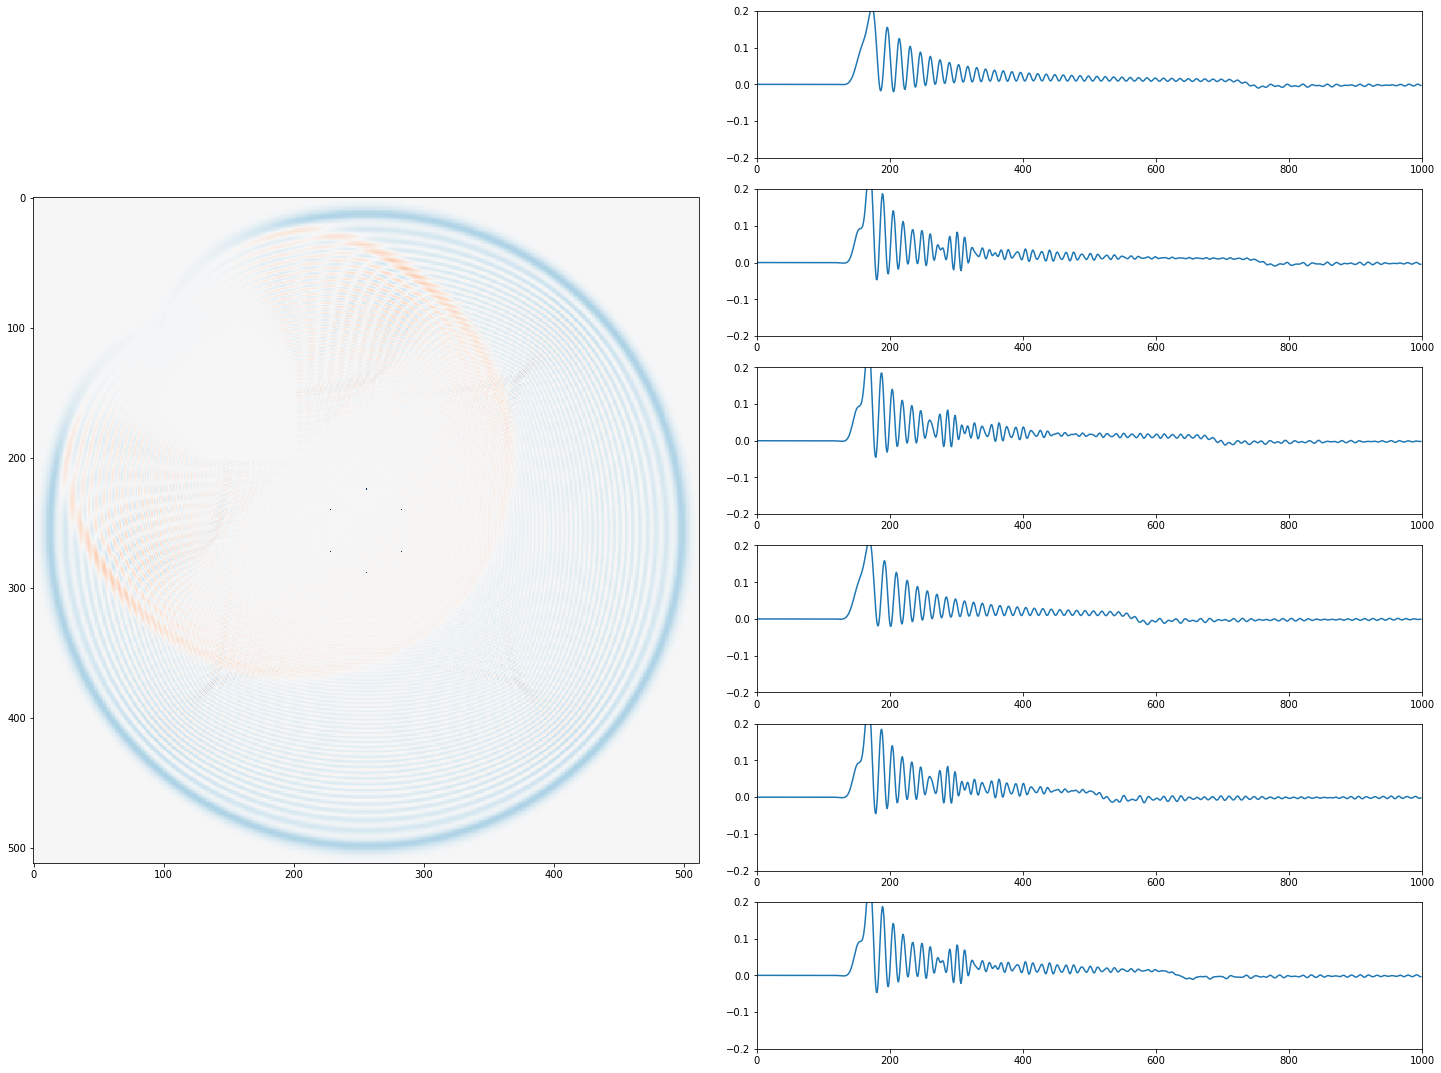

In [32]:
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

do_video = False
if do_video:
    # Number of frames to skip
    skip = 1

    # Decimate display data if needed
    if skip > 1:
        display_data = dataset[:domain.frames:skip]
    else:
        display_data = dataset
    display_frames = domain.frames // skip
    
    animation_fps = 25
    animation_bitrate = 3600
    
    # For display only
    video_data = np.copy(display_data)
    for mic in mics:
        video_data[:, int(mic.x), int(mic.y)] = vmax

    # Set up figure
    fig, axes = plt.subplots(n_mics, 2, figsize=(20,15))

    # Rightmost axes are for the microphone signals
    signal_axes = axes[:,1]

    # Leftmost axes are for the wave simulation animation
    anim_ax = plt.subplot2grid((n_mics, 2), (0, 0), rowspan=n_mics)

    # Initialize microphone signals and animations
    lines = [ax.plot([], [])[0] for ax in signal_axes]
    corrs = [ax.plot([], [])[0] for ax in signal_axes]
    anim = anim_ax.imshow(np.zeros((domain.width, domain.height)))

    # Update function for FuncAnimation
    milestone = 0
    def update(i):
        global milestone
        anim_ax.clear()
        anim_ax.imshow(
            video_data[i],
            vmin=vmin,
            vmax=vmax,
            cmap=cm.RdBu,
        )

        # Set common time axis values
        if skip > 1:
            t = np.arange(0, i*skip-1, skip)
        else:
            t = np.arange(0, i)

        # Set data for signals
        for n, line in enumerate(lines):
            line.set_data(t, signals[n][:i])

        # Print update on every milestone frame
        if i > milestone:
            print(f'Frame {i}/{display_frames}')
            milestone += display_frames / 12

        # Return artists
        return (*lines, anim)

    # Initialize plot layout
    plt.tight_layout()
    fig = plt.gcf()

    # Initialize signal axes
    for ax in signal_axes:
        ax.set_xlim(0, domain.frames)
        ax.set_ylim(vmin, vmax)

    # Create animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(1, int(domain.frames/skip)),
        blit=True,
        interval=10,
        repeat=False
    )

    # Save movie
    ani.save(
        "movie.mp4",
        writer=FFMpegWriter(
            fps=animation_fps,
            bitrate=animation_bitrate
        )
    )


# 4 Passive sonar

Coming eventually!